In [1]:
# 생성자는 판별자가 구별할 수 없을 만큼 정교한 가짜를 만드는 것이 목적이다

#### 생성자(generator)
  - 초기에는 무작위의 픽셀 값으로 채워진 가짜 이미지로 시작
  - DCGAN은 생성자 신경망으로 CNN을 이용
  - optimizer, compile 필요 없다 -> 판별은 discriminator가 한다
  - 원래 이미지의 크기를 위해서, 컨벌러젼 후 --> 패딩(padding)을 해줘야 한다
  - padding(upsampling)을 하고, pooling(undersampling)을 하면 안된다
  - 중간 활성화 함수 Relu(), 판별자로 넘겨주기 직전에는 tanh()함


#### DCGAN에서의 배치 정규화(Batch Normalization)
  - 배치 정규화 : 입력 데이터의 평균 0, 분산 1로 재배치
  - keras의 BatchNormalization()함수 이용

#### 판별자(discrimator)
  - 패딩, ReLU활성화 함수, 드롭 아웃(drop out): 속도가 느려짐 --> 신경망 구조 사용
  - 손실함수 : binary_croessentropy , 최정화 함수 : adam
  - discrimator은 판별만 하고 학습 해서는 안된다
  - 판별자를 만들 때는 가중치를 저장하는 학습 기능을 꺼주어야 함

In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential,Model
from keras.layers import Dense,BatchNormalization,Conv2D,MaxPooling2D,UpSampling2D,Reshape,LeakyReLU,Activation,Dropout,Flatten,Input
from keras.datasets import mnist

In [22]:
## 생성자 모델
generator= Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
## 판별자 모델
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable=False
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다

ginput =Input(shape=(100,))
dis_output=discriminator(generator(ginput))
gan=Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_21 (Sequential)  (None, 28, 28, 1)         865281    
                                                                 
 sequential_22 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [46]:
# 신경망을 실행시키는 함수를 만듭니다,
def gan_train(epoch, batch_size, saving_interval):

    # MNIST 데이터 불러오기
    (X_train,_),(_,_)=mnist.load_data()   ## mnist불러오기
    print(X_train.shape)
    X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
    X_train = (X_train-127.5)/127.5       ## -1,1사이의 값으로 바꿈
    true= np.ones((batch_size,1))
    fake= np.zeros((batch_size,1))

    for i in range(epoch):
        # 실제 데이터 판별자(discrimator)에 입력
        idx= np.random.randint(0,X_train.shape[0], batch_size)
        imgs= X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        # print(d_loss_real)

        # 가상 데이터 판별자(discrimator)에 입력
        noise= np.random.normal(0,1,(batch_size,100))
        gen_imgs= generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # print(d_loss_fake)

        # 판별자와 생성자의 오차 계산
        d_loss= 0.5 * np.add(d_loss_real,d_loss_fake)
        # print(d_loss)
        g_loss = gan.train_on_batch(noise, true)
        # print(g_loss)
        print('epoch:%d' % i,'d_loss:%.4f'%d_loss, 'g_loss:%.4f' %g_loss)

        if i % saving_interval == 0 :
            # r.c = 5.5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5) :
                for k in range(5) :
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap="gray")
                    axs[j, k].axis("off")
                    count += 1
                    fig.savefig("gan_images/gan_mnist_%d.png" % i)



(60000, 28, 28)
1/1 [==============================] - 0s 32ms/step
epoch:0 d_loss:0.0139 g_loss:2.8146
1/1 [==============================] - 0s 30ms/step
epoch:1 d_loss:0.0361 g_loss:2.4117
1/1 [==============================] - 0s 29ms/step
epoch:2 d_loss:0.0656 g_loss:2.5894
1/1 [==============================] - 0s 29ms/step
epoch:3 d_loss:0.1380 g_loss:3.1724
1/1 [==============================] - 0s 31ms/step
epoch:4 d_loss:0.2780 g_loss:2.9658
1/1 [==============================] - 0s 30ms/step
epoch:5 d_loss:0.1995 g_loss:5.0264
1/1 [==============================] - 0s 30ms/step
epoch:6 d_loss:0.1651 g_loss:4.3885
1/1 [==============================] - 0s 39ms/step
epoch:7 d_loss:0.8344 g_loss:4.3916
1/1 [==============================] - 0s 32ms/step
epoch:8 d_loss:0.4987 g_loss:2.4797
1/1 [==============================] - 0s 31ms/step
epoch:9 d_loss:0.5670 g_loss:2.3056
1/1 [==============================] - 0s 29ms/step
epoch:10 d_loss:0.4913 g_loss:3.1618
1/1 [==========

C:\Users\dgh06\AppData\Local\Temp\ipykernel_2668\545024077.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5, 5)


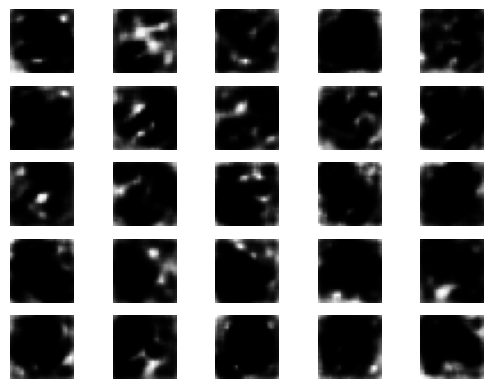

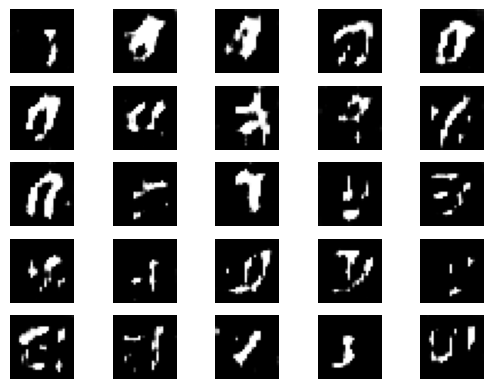

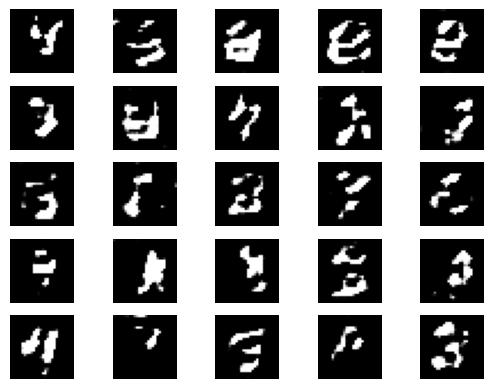

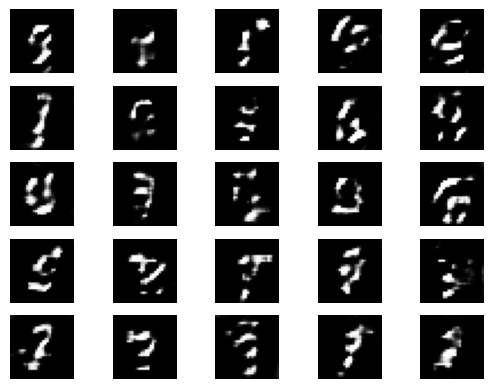

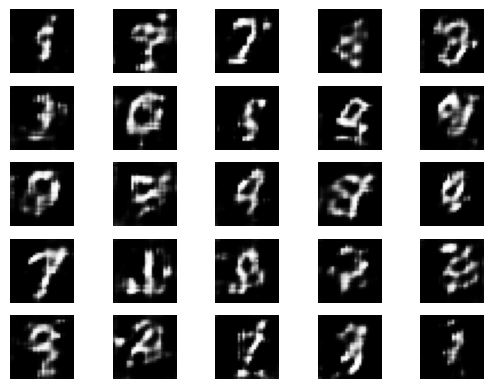

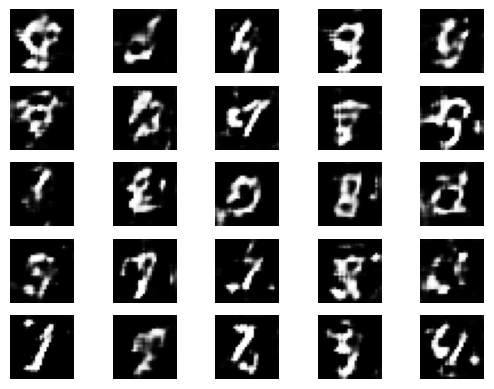

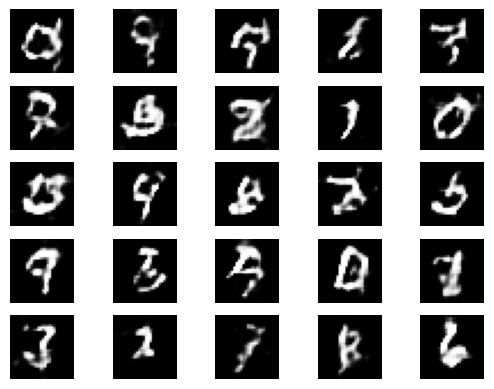

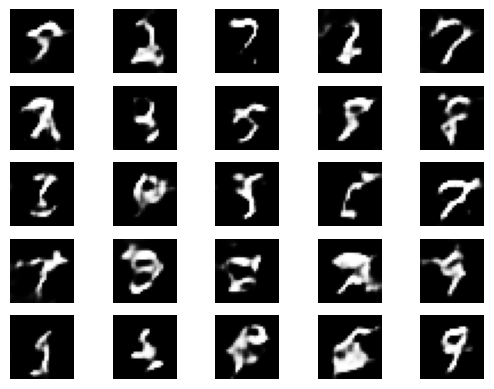

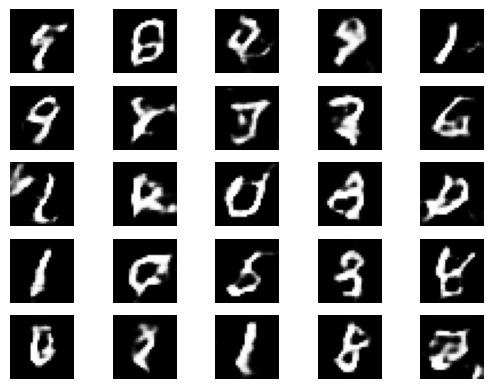

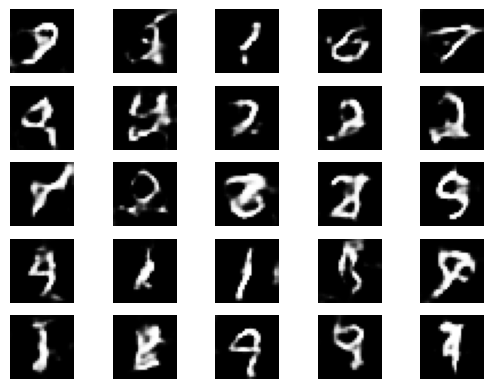

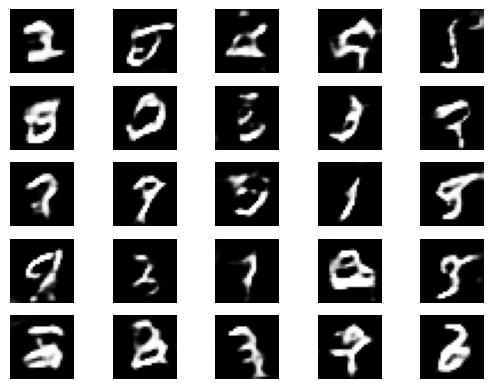

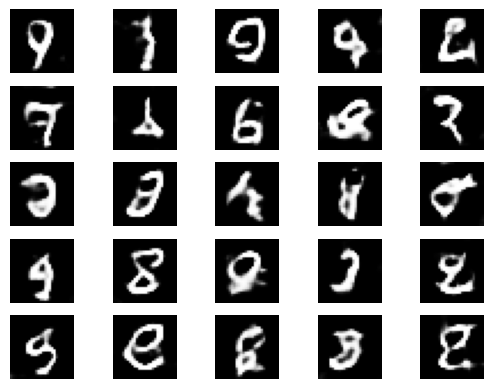

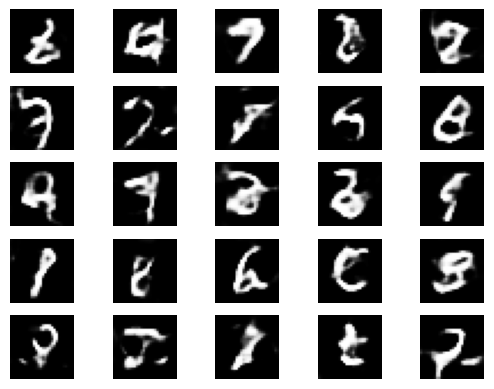

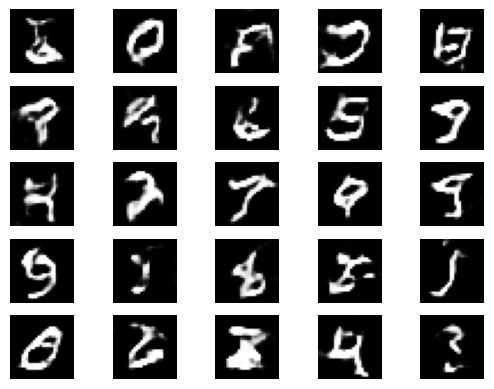

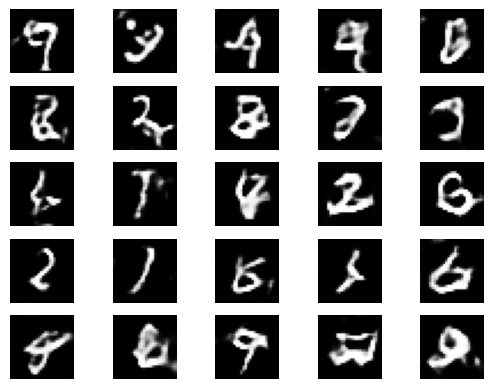

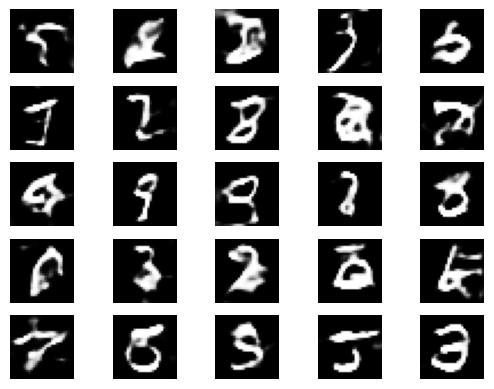

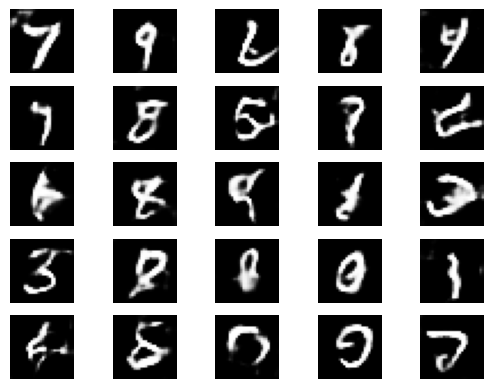

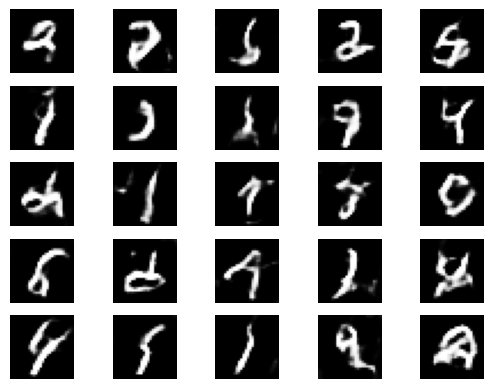

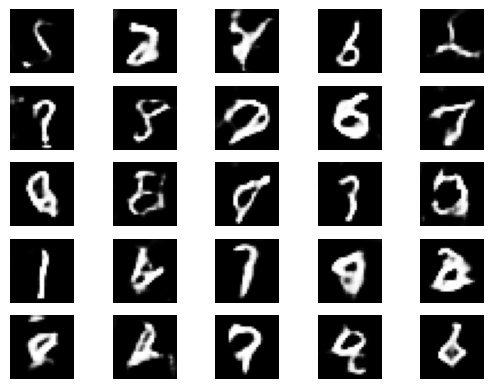

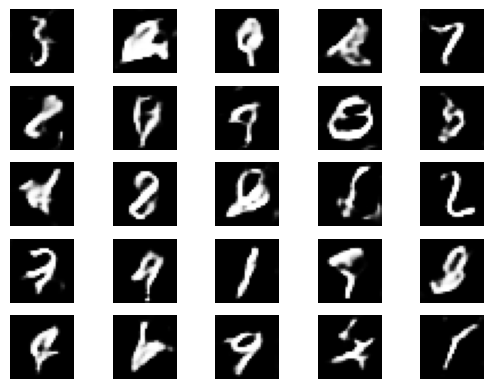

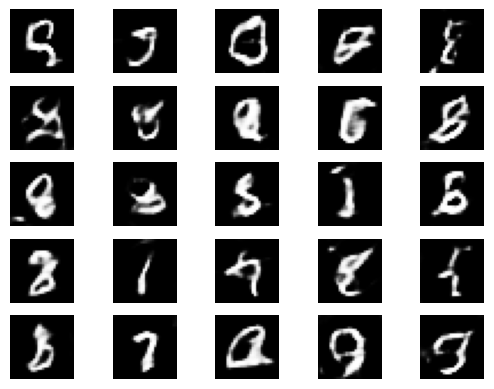

In [47]:
gan_train(4001,32,200)